In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
import cv2
import datetime
import os
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [4]:
total_frames = 30

In [5]:
frames_to_sample = 30
image_height = 120
image_width = 120
channels = 3

In [6]:
def generator(source_path, folder_list, augment=False):
    img_idx = np.round(np.linspace(0, total_frames - 1, frames_to_sample)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        for batch in range(num_batches):
            seq_len = min(batch_size, len(t) - batch * batch_size)

            batch_data = np.zeros((seq_len, len(img_idx), image_height, image_width, channels))
            batch_labels = np.zeros((seq_len, 5))

            if augment:
                batch_data_aug = np.zeros((seq_len, len(img_idx), image_height, image_width, channels))

            for folder in range(seq_len):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Performing image reading and resizing
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image_resized = resize(image, (image_height, image_width, 3))

                    # Normalizing the images
                    batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                    if augment:
                        shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30, 30)],
                                                                  [0, 1, np.random.randint(-30, 30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # Cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped = shifted[x0:x1, y0:y1, :]

                        image_resized = resize(cropped, (image_height, image_width, 3))

                        batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                        batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                        batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            if augment:
                batch_data = np.concatenate([batch_data, batch_data_aug])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels

        remaining_seq = len(t) % batch_size

        if remaining_seq != 0:
            seq_len = remaining_seq

            batch_data = np.zeros((seq_len, len(img_idx), image_height, image_width, channels))
            batch_labels = np.zeros((seq_len, 5))

            if augment:
                batch_data_aug = np.zeros((seq_len, len(img_idx), image_height, image_width, channels))

            for folder in range(seq_len):
                imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Performing image reading and resizing
                    image = imread(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image_resized = resize(image, (image_height, image_width, 3))

                    # Normalizing the images
                    batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                    if augment:
                        shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30, 30)],
                                                                  [0, 1, np.random.randint(-30, 30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # Cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped = shifted[x0:x1, y0:y1, :]

                        image_resized = resize(cropped, (image_height, image_width, 3))

                        batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                        batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                        batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1

            if augment:
                batch_data = np.concatenate([batch_data, batch_data_aug])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels


In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [89]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, regularizers

In [9]:
image_height = 120
image_width = 120
channels = 3

In [10]:
train_generator = generator(train_path, train_doc, True)
val_generator = generator(val_path, val_doc, False)

In [104]:
def init_model_checkpoint(is_early_stopping = True):
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    if is_early_stopping == True:
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]
        return callbacks_list
    callbacks_list = [checkpoint, LR]
    return callbacks_list



In [12]:
def calculate_steps_for_validation_epoch():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return(steps_per_epoch, validation_steps)


In [13]:
frames_to_sample = 20
batch_size = 40
num_epochs = 15

In [14]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
            input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
#optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 60, 60, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    4

In [15]:
def plot_comparison_of_accuracy(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [16]:
callbacks_list = init_model_checkpoint()
steps_per_epoch, validation_steps = calculate_steps_for_validation_epoch()

In [17]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/_p/l2hq10612h35xnw7k6f17qsm0000gq/T/ipykernel_93225/3366497004.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6889 - categorical_accuracy: 0.4065 
Epoch 1: saving model to model_init_2023-11-0722_01_28.846812/model-00001-1.68892-0.40649-1.55579-0.29000.h5
17/17 [==============================] - 327s 19s/step - loss: 1.6889 - categorical_accuracy: 0.4065 - val_loss: 1.5558 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 1.1074 - categorical_accuracy: 0.5709 
Epoch 2: saving model to model_init_2023-11-0722_01_28.846812/model-00002-1.10743-0.57089-2.20188-0.27000.h5
17/17 [==============================] - 293s 17s/step - loss: 1.1074 - categorical_accuracy: 0.5709 - val_loss: 2.2019 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8964 - categorical_accuracy: 0.6606 
Epoch 3: saving model to model_init_2023-11-0722_01_28.846812/model-00003-0.89641-0.66063-3.03548-0.24000.h5
17/17 [==============================] - 295s 17s/step - loss: 0.8964 - categorical_accuracy: 0.6606 - val_loss: 3.0355 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 4/15
17/17 [==============================] - ETA: 0s - loss: 0.6987 - categorical_accuracy: 0.7315 
Epoch 4: saving model to model_init_2023-11-0722_01_28.846812/model-00004-0.69873-0.73152-3.79641-0.17000.h5
17/17 [====================

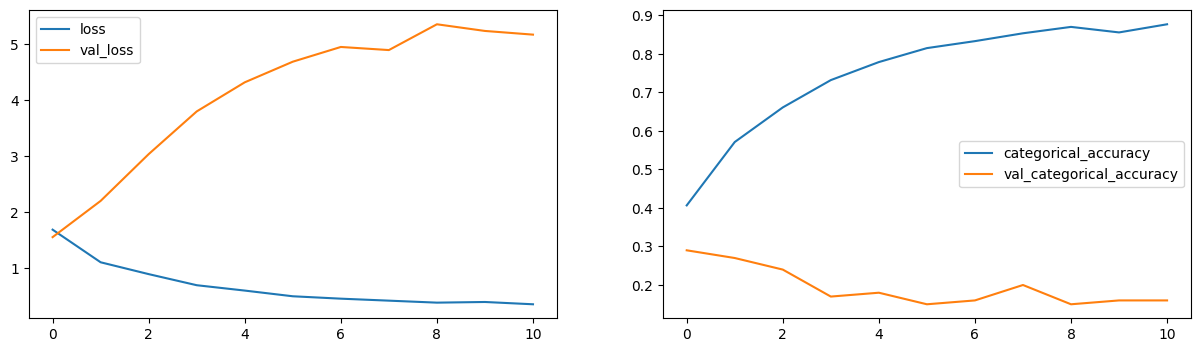

In [18]:
plot_comparison_of_accuracy(history)

In [19]:
batch_size = 10
num_epochs = 15

In [20]:
frames_to_sample = 16
image_height = 100
image_width = 100

In [23]:
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.legacy.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16   400       
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 16, 100, 100, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 8, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)    

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/_p/l2hq10612h35xnw7k6f17qsm0000gq/T/ipykernel_93225/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 2.0366 - categorical_accuracy: 0.3098
Epoch 1: saving model to model_init_2023-11-0722_01_28.846812/model-00001-2.03664-0.30982-3.90206-0.23333.h5
17/17 [==============================] - 45s 3s/step - loss: 2.0366 - categorical_accuracy: 0.3098 - val_loss: 3.9021 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 2/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 1.4579 - categorical_accuracy: 0.4588
Epoch 2: saving model to model_init_2023-11-0722_01_28.846812/model-00002-1.45792-0.45882-1.51169-0.36667.h5
17/17 [==============================] - 47s 3s/step - loss: 1.4579 - categorical_accuracy: 0.4588 - val_loss: 1.5117 - val_categorical_accuracy: 0.3667 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.5734 - categorical_accuracy: 0.4118
Epoch 3: saving model to model_init_2023-11-0722_01_28.846812/model-00003-1.57337-0.41176-1.58866-0.30000.h5
17/17 [==============================] - 47s 3s/step - loss: 1.5734 - categorical_accuracy: 0.4118 - val_loss: 1.5887 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 4/15
17/17 [==============================] - ETA: 0s - loss: 1.6137 - categorical_accuracy: 0.4029
Epoch 4: saving model to model_init_2023-11-0722_01_28.846812/model-00004-1.61373-0.40294-1.51250-0.26667.h5
17/17 [===========================

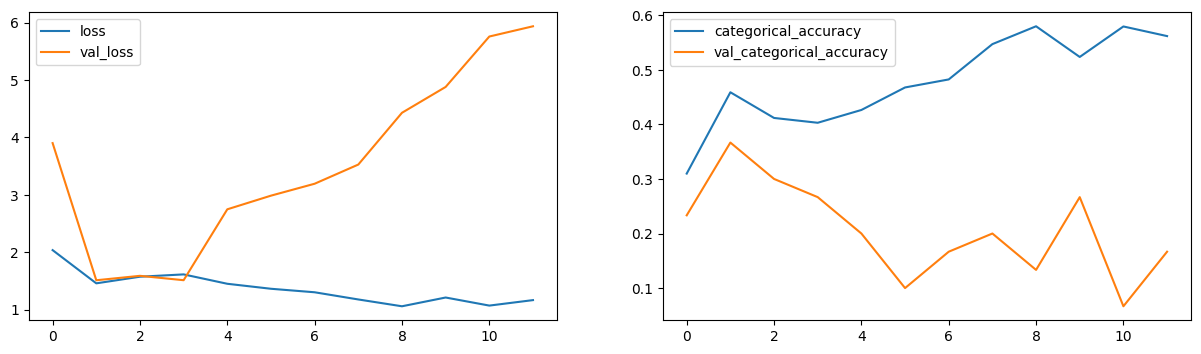

In [25]:
plot_comparison_of_accuracy(history)

In [37]:
batch_size = 10
num_epochs = 30

In [38]:
frames_to_sample = 10
image_height = 120
image_width = 120

In [43]:
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(16, (2, 2, 2), padding='same',input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu', bias_regularizer=regularizers.L1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu', bias_regularizer=regularizers.L1(0.01)))
model.add(BatchNormalization()) 
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 10, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_64 (Activation)  (None, 10, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_76 (Ba  (None, 10, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_65 (Conv3D)          (None, 10, 120, 120, 16   2064      
                             )                                   
                                                                 
 activation_65 (Activation)  (None, 10, 120, 120, 16 

In [44]:
callbacks_list = init_model_checkpoint()
steps_per_epoch, validation_steps = calculate_steps_for_validation_epoch()

In [45]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/_p/l2hq10612h35xnw7k6f17qsm0000gq/T/ipykernel_93225/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.8808 - categorical_accuracy: 0.3054
Epoch 1: saving model to model_init_2023-11-0722_01_28.846812/model-00001-1.88081-0.30543-1.74162-0.17000.h5
67/67 [==============================] - 403s 6s/step - loss: 1.8808 - categorical_accuracy: 0.3054 - val_loss: 1.7416 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.6268 - categorical_accuracy: 0.3643
Epoch 2: saving model to model_init_2023-11-0722_01_28.846812/model-00002-1.62678-0.36425-3.60552-0.13000.h5
67/67 [==============================] - 403s 6s/step - loss: 1.6268 - categorical_accuracy: 0.3643 - val_loss: 3.6055 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.5317 - categorical_accuracy: 0.3839
Epoch 3: saving model to model_init_2023-11-0722_01_28.846812/model-00003-1.53167-0.38386-3.16033-0.16000.h5
67/67 [==============================] - 400s 6s/step - loss: 1.5317 - categorical_accuracy: 0.3839 - val_loss: 3.1603 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 1.4270 - categorical_accuracy: 0.4125
Epoch 4: saving model to model_init_2023-11-0722_01_28.846812/model-00004-1.42695-0.41252-5.53639-0.19000.h5
67/67 [=========================

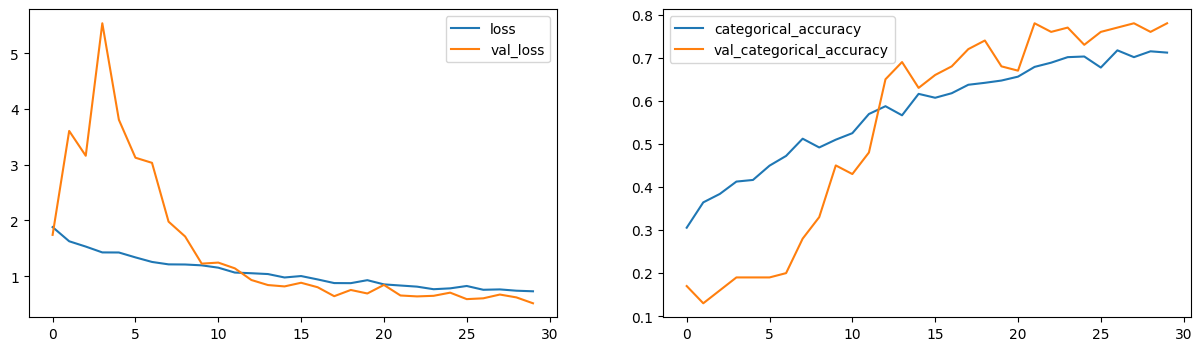

In [46]:
plot_comparison_of_accuracy(history)

In [79]:
batch_size = 15
num_epochs = 25

In [80]:
frames_to_sample = 10
image_height = 120
image_width = 120

In [81]:
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(16, (2, 2, 2), padding='same',input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_112 (Conv3D)         (None, 10, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_112 (Activation  (None, 10, 120, 120, 16   0         
 )                           )                                   
                                                                 
 batch_normalization_138 (B  (None, 10, 120, 120, 16   64        
 atchNormalization)          )                                   
                                                                 
 conv3d_113 (Conv3D)         (None, 10, 120, 120, 16   2064      
                             )                                   
                                                                 
 activation_113 (Activation  (None, 10, 120, 120, 16 

In [82]:
callbacks_list = init_model_checkpoint()
steps_per_epoch, validation_steps = calculate_steps_for_validation_epoch()

In [83]:
train_generator = generator(train_path, train_doc, True)
val_generator = generator(val_path, val_doc, False)

In [84]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/_p/l2hq10612h35xnw7k6f17qsm0000gq/T/ipykernel_93225/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.4170
Epoch 1: saving model to model_init_2023-11-0722_01_28.846812/model-00001-1.60965-0.41704-2.44381-0.16000.h5
45/45 [==============================] - 192s 4s/step - loss: 1.6096 - categorical_accuracy: 0.4170 - val_loss: 2.4438 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.2331 - categorical_accuracy: 0.5204
Epoch 2: saving model to model_init_2023-11-0722_01_28.846812/model-00002-1.23308-0.52036-3.32134-0.17000.h5
45/45 [==============================] - 202s 4s/step - loss: 1.2331 - categorical_accuracy: 0.5204 - val_loss: 3.3213 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.0189 - categorical_accuracy: 0.6094
Epoch 3: saving model to model_init_2023-11-0722_01_28.846812/model-00003-1.01890-0.60935-2.74788-0.19000.h5
45/45 [==============

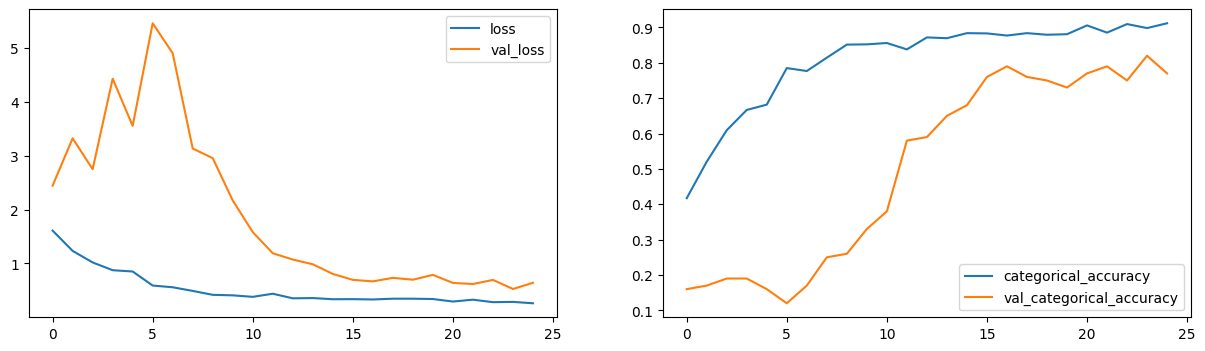

In [85]:
plot_comparison_of_accuracy(history)

In [99]:
batch_size = 15
num_epochs = 20

In [100]:
frames_to_sample = 10
image_height = 100
image_width = 100

In [101]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                            input_shape=(frames_to_sample,image_height,image_width,channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeD  (None, 10, 100, 100, 16   208       
 istributed)                 )                                   
                                                                 
 time_distributed_33 (TimeD  (None, 10, 100, 100, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_34 (TimeD  (None, 10, 50, 50, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_35 (TimeD  (None, 10, 50, 50, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 10, 50, 50, 32)  

In [105]:
callbacks_list = init_model_checkpoint(is_early_stopping=False)
steps_per_epoch, validation_steps = calculate_steps_for_validation_epoch()

In [106]:
train_generator = generator(train_path, train_doc, True)
val_generator = generator(val_path, val_doc, False)

In [107]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/_p/l2hq10612h35xnw7k6f17qsm0000gq/T/ipykernel_93225/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.3479 - categorical_accuracy: 0.4201
Epoch 1: saving model to model_init_2023-11-0722_01_28.846812/model-00001-1.34787-0.42006-2.18214-0.19000.h5
45/45 [==============================] - 66s 1s/step - loss: 1.3479 - categorical_accuracy: 0.4201 - val_loss: 2.1821 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 1.1226 - categorical_accuracy: 0.5347
Epoch 2: saving model to model_init_2023-11-0722_01_28.846812/model-00002-1.12261-0.53469-2.43909-0.21000.h5
45/45 [==============================] - 62s 1s/step - loss: 1.1226 - categorical_accuracy: 0.5347 - val_loss: 2.4391 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.9936 - categorical_accuracy: 0.5867
Epoch 3: saving model to model_init_2023-11-0722_01_28.846812/model-00003-0.99364-0.58673-1.92918-0.24000.h5
45/45 [==============================] - 60s 1s/step - loss: 0.9936 - categorical_accuracy: 0.5867 - val_loss: 1.9292 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - ETA: 0s - loss: 0.8318 - categorical_accuracy: 0.6727
Epoch 4: saving model to model_init_2023-11-0722_01_28.846812/model-00004-0.83177-0.67270-2.28856-0.20000.h5
45/45 [===========================

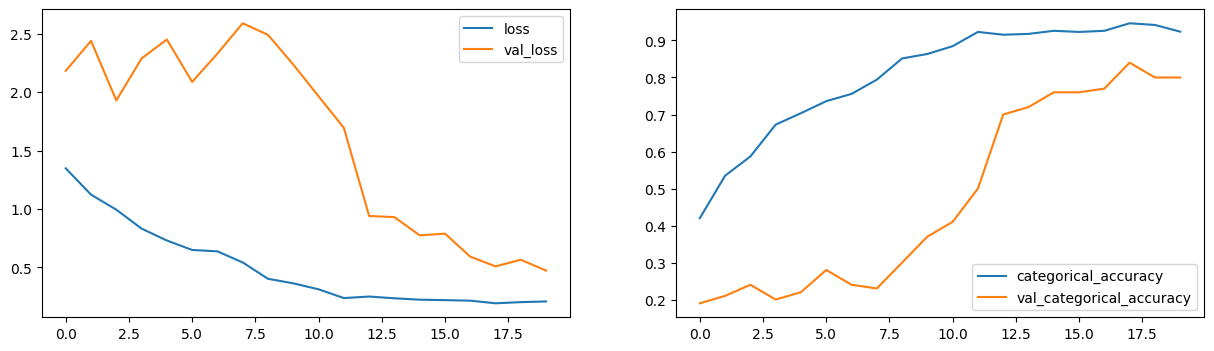

In [108]:
plot_comparison_of_accuracy(history)

In [109]:
from keras.applications import mobilenet

In [110]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 4s 0us/step


In [112]:
batch_size = 5
num_epochs = 20

In [113]:
frames_to_sample = 10
image_height = 100
image_width = 100

In [114]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,image_height,image_width,channels)))


for layer in model.layers:
    layer.trainable = False


model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeD  (None, 10, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_49 (TimeD  (None, 10, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_50 (TimeD  (None, 10, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_51 (TimeD  (None, 10, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 128)             

In [115]:
callbacks_list = init_model_checkpoint(is_early_stopping=False)
steps_per_epoch, validation_steps = calculate_steps_for_validation_epoch()

In [116]:
train_generator = generator(train_path, train_doc, True)
val_generator = generator(val_path, val_doc, False)

In [117]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/_p/l2hq10612h35xnw7k6f17qsm0000gq/T/ipykernel_93225/2585147562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3259 - categorical_accuracy: 0.4382
Epoch 1: saving model to model_init_2023-11-0722_01_28.846812/model-00001-1.32591-0.43816-0.99211-0.60000.h5
133/133 [==============================] - 65s 481ms/step - loss: 1.3259 - categorical_accuracy: 0.4382 - val_loss: 0.9921 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 2/20
  1/133 [..............................] - ETA: 15s - loss: 1.3770 - categorical_accuracy: 0.4000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - ETA: 0s - loss: 0.8693 - categorical_accuracy: 0.6561
Epoch 2: saving model to model_init_2023-11-0722_01_28.846812/model-00002-0.86926-0.65611-0.95008-0.64000.h5
133/133 [==============================] - 60s 454ms/step - loss: 0.8693 - categorical_accuracy: 0.6561 - val_loss: 0.9501 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6308 - categorical_accuracy: 0.7662
Epoch 3: saving model to model_init_2023-11-0722_01_28.846812/model-00003-0.63078-0.76621-0.84215-0.64000.h5
133/133 [==============================] - 59s 446ms/step - loss: 0.6308 - categorical_accuracy: 0.7662 - val_loss: 0.8422 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 4/20
133/133 [==============================] - ETA: 0s - loss: 0.4868 - categorical_accuracy: 0.8183
Epoch 4: saving model to model_init_2023-11-0722_01_28.846812/model-00004-0.48685-0.81825-0.88621-0.71000.h5
133/133 [=========

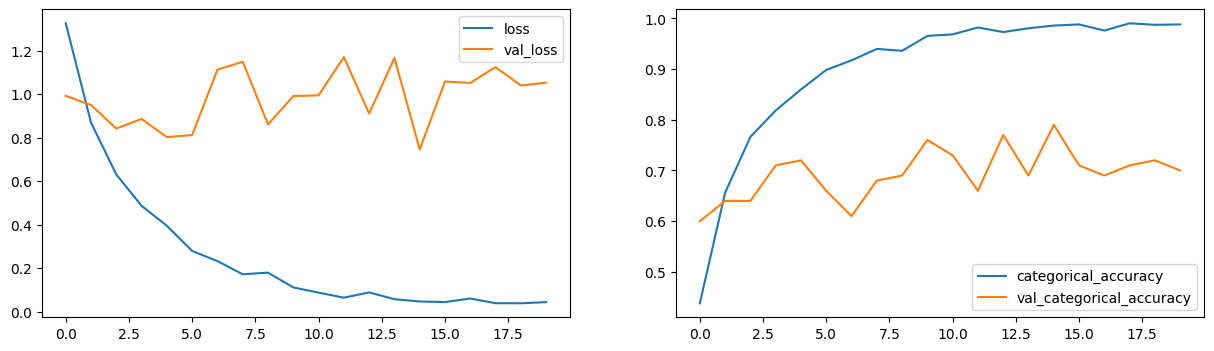

In [118]:
plot_comparison_of_accuracy(history)